<a href="https://colab.research.google.com/github/shivaansh81001/btc-prediction/blob/main/btc_data_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [244]:
from datascience import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

In [245]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [246]:
path='/content/drive/MyDrive/btc predict/'

In [247]:
TABLE_NAME='btcusd_1-min_data.csv'
data=Table().read_table(path+TABLE_NAME)
data.show(5)

Timestamp,Open,High,Low,Close,Volume
1.32541e+09,4.58,4.58,4.58,4.58,0
1.32541e+09,4.58,4.58,4.58,4.58,0
1.32541e+09,4.58,4.58,4.58,4.58,0
1.32541e+09,4.58,4.58,4.58,4.58,0
1.32541e+09,4.58,4.58,4.58,4.58,0


In [248]:
data= data.where("Timestamp",are.above_or_equal_to(1636520280))
data.show(5)

Timestamp,Open,High,Low,Close,Volume
1.63652e+09,66991.5,66991.5,66935.9,66935.9,2.06704
1.63652e+09,66937.1,66945.7,66927.5,66945.7,0.130802
1.63652e+09,66928.4,66988.9,66928.4,66972.1,0.031246
1.63652e+09,66995.5,67014.5,66995.5,67014.5,0.0697985
1.63652e+09,67018.2,67123.4,67007.5,67123.4,1.64906


In [249]:
def format_price(price):
  split_=price.split(',')
  return float(split_[0]+split_[1])

def format_vol(vol):
  split_=float(vol[:-1])*1000
  return split_

def format_change(change):
  return float(change[:-1])

def format_time(time):
  time=int(time)
  return str(datetime.utcfromtimestamp(time).strftime('%Y-%m-%d %H:%M:%S'))

def sum_volume_1h(vol):
  return [sum(vol[i:i+60]) for i in range(2, len(vol), 60)]

def calc_rsi(data ,period=14):
  delta= data.diff(1)
  gain= (delta.where(delta>0,0)).rolling(window=period).mean()
  loss= (-delta.where(delta<0,0)).rolling(window=period).mean()
  rs= gain/loss
  return 100- (100/(1+rs))

def calc_rsi_condition(rsi):
  condition=[]
  for i in rsi:
    if i>=70:
      condition.append(1)
    elif i<30:
      condition.append(-1)
    elif i>=30 and i<70:
      condition.append(0)
  return np.array(condition)

In [250]:
volsum_1h= sum_volume_1h(list(data.column("Volume")))

In [251]:
#volsum len
print(len(volsum_1h))

25896


In [252]:
#test format_price
print(format_price('95,284.5'))

#test format_vol
print(format_vol('61.62K'))

#test format_time
print(format_time(1734447660))

#vol sum
print(sum_volume_1h([x for x in range(1,361)]))

95284.5
61620.0
2024-12-17 15:01:00
[1950, 5550, 9150, 12750, 16350, 19227]


In [253]:
formatted_time = data.apply(format_time,"Timestamp")
data = data.with_column("Timestamp",formatted_time)

data.show(5)

Timestamp,Open,High,Low,Close,Volume
2021-11-10 04:58:00,66991.5,66991.5,66935.9,66935.9,2.06704
2021-11-10 04:59:00,66937.1,66945.7,66927.5,66945.7,0.130802
2021-11-10 05:00:00,66928.4,66988.9,66928.4,66972.1,0.031246
2021-11-10 05:01:00,66995.5,67014.5,66995.5,67014.5,0.0697985
2021-11-10 05:02:00,67018.2,67123.4,67007.5,67123.4,1.64906


In [254]:
data= data.take(np.arange(2,data.num_rows,60))
data.show(5)

Timestamp,Open,High,Low,Close,Volume
2021-11-10 05:00:00,66928.4,66988.9,66928.4,66972.1,0.031246
2021-11-10 06:00:00,66951.4,66951.4,66951.4,66951.4,0.002
2021-11-10 07:00:00,67047.1,67061.3,67038.8,67038.8,0.541149
2021-11-10 08:00:00,66811.9,66836.1,66734.4,66734.4,0.337868
2021-11-10 09:00:00,66530.3,66541.3,66526.9,66526.9,0.28869


In [255]:
data = data.with_column("vol traded", np.array(volsum_1h))

In [256]:
data.show(5)

Timestamp,Open,High,Low,Close,Volume,vol traded
2021-11-10 05:00:00,66928.4,66988.9,66928.4,66972.1,0.031246,43.442
2021-11-10 06:00:00,66951.4,66951.4,66951.4,66951.4,0.002,19.4884
2021-11-10 07:00:00,67047.1,67061.3,67038.8,67038.8,0.541149,22.8345
2021-11-10 08:00:00,66811.9,66836.1,66734.4,66734.4,0.337868,72.4226
2021-11-10 09:00:00,66530.3,66541.3,66526.9,66526.9,0.28869,40.5544


In [257]:
price_change_hourly= ((data.column("Close") - data.column("Open")) / data.column("Open")) *100
data = data.with_column("price_change_hourly",price_change_hourly)

In [258]:
data.sort("Timestamp",descending=True).show(5)

Timestamp,Open,High,Low,Close,Volume,vol traded,price_change_hourly
2025-01-02 23:20:00,96816,96819,96793,96793,0.198558,2.97368,-0.0237564
2025-01-02 22:20:00,96800,96800,96775,96776,0.00391808,11.3632,-0.0247934
2025-01-02 21:20:00,97114,97114,97091,97091,0.0252511,14.8473,-0.0236835
2025-01-02 20:20:00,97703,97719,97676,97719,0.305568,18.0116,0.0163762
2025-01-02 19:20:00,97474,97499,97474,97491,0.156311,16.3315,0.0174405


In [259]:
volume_change_hourly = data.to_df()['vol traded'].pct_change()*100
data = data.with_column("volume_change_hourly",volume_change_hourly)


In [260]:
data.show(5)

Timestamp,Open,High,Low,Close,Volume,vol traded,price_change_hourly,volume_change_hourly
2021-11-10 05:00:00,66928.4,66988.9,66928.4,66972.1,0.031246,43.442,0.065204,nan
2021-11-10 06:00:00,66951.4,66951.4,66951.4,66951.4,0.002,19.4884,0,-55.1392
2021-11-10 07:00:00,67047.1,67061.3,67038.8,67038.8,0.541149,22.8345,-0.0123943,17.1694
2021-11-10 08:00:00,66811.9,66836.1,66734.4,66734.4,0.337868,72.4226,-0.115937,217.163
2021-11-10 09:00:00,66530.3,66541.3,66526.9,66526.9,0.28869,40.5544,-0.00511045,-44.0032


In [261]:
data= data.exclude(0)
data.show(5)

Timestamp,Open,High,Low,Close,Volume,vol traded,price_change_hourly,volume_change_hourly
2021-11-10 06:00:00,66951.4,66951.4,66951.4,66951.4,0.002,19.4884,0,-55.1392
2021-11-10 07:00:00,67047.1,67061.3,67038.8,67038.8,0.541149,22.8345,-0.0123943,17.1694
2021-11-10 08:00:00,66811.9,66836.1,66734.4,66734.4,0.337868,72.4226,-0.115937,217.163
2021-11-10 09:00:00,66530.3,66541.3,66526.9,66526.9,0.28869,40.5544,-0.00511045,-44.0032
2021-11-10 10:00:00,66649.7,66650,66643.5,66644.5,2.05988,27.0178,-0.00790701,-33.3789


In [262]:
data = data.to_df()

In [263]:
data['EMA_12h']= data['Close'].ewm(span=12,adjust=False).mean()
data['EMA_48h']= data['Close'].ewm(span=48,adjust=False).mean()
data.dropna(inplace=True)

data= data.iloc[47:]



In [264]:
data['rsi_14']=calc_rsi(data['Close'])
data= data.dropna()
data['rsi_14'].fillna(0,inplace=True)


<ipython-input-264-6b027e2b6d62>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['rsi_14'].fillna(0,inplace=True)


In [265]:
data= Table().from_df(data)

In [266]:
data.show(5)

Timestamp,Open,High,Low,Close,Volume,vol traded,price_change_hourly,volume_change_hourly,EMA_12h,EMA_48h,rsi_14
2021-11-12 18:00:00,63837.8,63837.8,63764.8,63775.6,0.986303,197.648,-0.0974188,115.214,64297.3,65135.7,33.5866
2021-11-12 19:00:00,64002.8,64082.2,63985.9,64056.3,1.64629,152.463,0.0835432,-22.8613,64260.3,65091.7,39.2037
2021-11-12 20:00:00,63471.8,63559.4,63463,63468.4,2.67954,253.223,-0.00527794,66.0886,64138.4,65025.4,32.108
2021-11-12 21:00:00,63198.4,63198.4,63107.7,63131.4,0.471377,214.01,-0.105984,-15.4857,63983.5,64948.1,24.2103
2021-11-12 22:00:00,63086.8,63086.8,63016.2,63046.5,4.61578,107.546,-0.0638485,-49.7473,63839.4,64870.5,24.0348


In [267]:
rsi_condition=calc_rsi_condition(data.column('rsi_14'))
print(rsi_condition)
print(not(any(rsi_condition)))
print(len(rsi_condition))
data=data.with_column("rsi_condition",rsi_condition)

[0 0 0 ..., 1 0 0]
False
25835


In [268]:
data.show(10)

Timestamp,Open,High,Low,Close,Volume,vol traded,price_change_hourly,volume_change_hourly,EMA_12h,EMA_48h,rsi_14,rsi_condition
2021-11-12 18:00:00,63837.8,63837.8,63764.8,63775.6,0.986303,197.648,-0.0974188,115.214,64297.3,65135.7,33.5866,0
2021-11-12 19:00:00,64002.8,64082.2,63985.9,64056.3,1.64629,152.463,0.0835432,-22.8613,64260.3,65091.7,39.2037,0
2021-11-12 20:00:00,63471.8,63559.4,63463,63468.4,2.67954,253.223,-0.00527794,66.0886,64138.4,65025.4,32.108,0
2021-11-12 21:00:00,63198.4,63198.4,63107.7,63131.4,0.471377,214.01,-0.105984,-15.4857,63983.5,64948.1,24.2103,-1
2021-11-12 22:00:00,63086.8,63086.8,63016.2,63046.5,4.61578,107.546,-0.0638485,-49.7473,63839.4,64870.5,24.0348,-1
2021-11-12 23:00:00,63625.4,63669.5,63618.2,63618.2,4.81815,199.84,-0.0111905,85.8184,63805.3,64819.4,35.5609,0
2021-11-13 00:00:00,63908.1,63931,63908.1,63927.7,0.0260882,56.9967,0.0305751,-71.4788,63824.2,64783,37.9433,0
2021-11-13 01:00:00,63853.7,63885.9,63853.7,63885.9,0.125687,121.739,0.0504904,113.59,63833.7,64746.4,40.5547,0
2021-11-13 02:00:00,64162.9,64225.7,64157.1,64191.7,5.23441,95.3941,0.0448858,-21.6407,63888.7,64723.7,45.6573,0
2021-11-13 03:00:00,64131.2,64149.9,64115.7,64143,0.236951,28.9577,0.0183842,-69.6441,63927.9,64700,46.2002,0


In [269]:
'''%matplotlib inline

data.plot("Date","Price")

data.plot("Date","Change %")

data.scatter('Date',"Price")'''


'%matplotlib inline\n\ndata.plot("Date","Price")\n\ndata.plot("Date","Change %")\n\ndata.scatter(\'Date\',"Price")'

# new source #

In [270]:
news= Table.read_table(path+'cryptonews.csv').drop('url','source','title')
news = news.where("subject",are.equal_to("bitcoin"))
news.show(10)


date,sentiment,subject,text
2023-12-19 05:25:00,"{'class': 'negative', 'polarity': -0.01, 'subjectivity': ...",bitcoin,"Yonsei found that during BTC’s rally in early December, ..."
2023-12-19 04:50:11,"{'class': 'positive', 'polarity': 0.3, 'subjectivity': 0.1}",bitcoin,"Cathie Wood led ARK Invest fund sold around 809, 441 Gra ..."
2023-12-19 04:10:00,"{'class': 'neutral', 'polarity': 0.0, 'subjectivity': 0.0}",bitcoin,Bitcoin's 150% surge pales in comparison to the staggeri ...
2023-12-19 02:59:59,"{'class': 'negative', 'polarity': -0.08, 'subjectivity': ...",bitcoin,The SEC has pushed back its decision on a roster of Ethe ...
2023-12-18 18:33:34,"{'class': 'negative', 'polarity': -0.27, 'subjectivity': ...",bitcoin,"Bitcoin may remain under pressure for a few days, but a ..."
2023-12-18 18:15:45,"{'class': 'neutral', 'polarity': 0.0, 'subjectivity': 0.0}",bitcoin,The ad spot came as the U.S. Securities and Exchange Com ...
2023-12-18 18:11:43,"{'class': 'positive', 'polarity': 0.3, 'subjectivity': 0.45}",bitcoin,"Bitcoin (BTC), the world's most valuable cryptocurrency, ..."
2023-12-18 17:55:00,"{'class': 'positive', 'polarity': 0.2, 'subjectivity': 0.7}",bitcoin,"Since the famous meme post to BitcoinTalk, Bitcoin (BTC) ..."
2023-12-18 17:01:00,"{'class': 'positive', 'polarity': 0.05, 'subjectivity': ...",bitcoin,"CoinShares said the ""mixed regional flows"" are more indi ..."
2023-12-18 15:42:27,"{'class': 'negative', 'polarity': -0.1, 'subjectivity': 0.2}",bitcoin,Digital asset mining firm Hut 8 signed an interim agreem ...


In [271]:
#test cell for sentiment
print(news.take(0).column("text")[0])

news.sort("date",descending=False).show(3)

Yonsei found that during BTC’s rally in early December, the Binary CDD was also active, signaling recent activity by short-term holders.


date,sentiment,subject,text
2021-11-10 04:58:00,"{'class': 'neutral', 'polarity': 0.0, 'subjectivity': 0.0}",bitcoin,"Bitcoin price is correcting gains below USD 67,000. Ethe ..."
2021-11-10 11:09:00,"{'class': 'negative', 'polarity': -0.02, 'subjectivity': ...",bitcoin,The much-awaited wallet is scheduled to be launched late ...
2021-11-10 13:10:00,"{'class': 'neutral', 'polarity': 0.0, 'subjectivity': 0.0}",bitcoin,Bitcoin price is struggling to gain momentum for a move ...


In [272]:
print(type(news.column("date").take(0)))

<class 'numpy.str_'>


In [273]:
def date_fix(date):
  return date[:-2]+'00'

In [274]:
#test date_fix
print(date_fix('2021-11-10 13:10:11'))

2021-11-10 13:10:00


In [275]:
class_ = []
polarity_ = []
subjectivity_ = []

for row in news.column("sentiment"):
  row=eval(row)
  if row['class']=='neutral':
    class_.append(0)
  elif row['class']=='negative':
    class_.append(-1)
  elif row['class']=='positive':
    class_.append(1)


  polarity_.append(row['polarity'])
  subjectivity_.append(row['subjectivity'])

class_,polarity_,subjectivity_=map(np.array,(class_,polarity_,subjectivity_))
print(class_,polarity_,subjectivity_)

fixed_date = news.apply(date_fix,'date')


news = news.with_columns("class",class_,"polarity",polarity_,"subjectivity",subjectivity_,"date",fixed_date).drop('sentiment')

news.sort("date",descending=True).show(5)



[-1  1  0 ...,  0 -1  0] [-0.01  0.3   0.   ...,  0.   -0.02  0.  ] [ 0.38  0.1   0.   ...,  0.    0.47  0.  ]


date,subject,text,class,polarity,subjectivity
2023-12-19 05:25:00,bitcoin,"Yonsei found that during BTC’s rally in early December, ...",-1,-0.01,0.38
2023-12-19 04:50:00,bitcoin,"Cathie Wood led ARK Invest fund sold around 809, 441 Gra ...",1,0.3,0.1
2023-12-19 04:10:00,bitcoin,Bitcoin's 150% surge pales in comparison to the staggeri ...,0,0,0
2023-12-19 02:59:00,bitcoin,The SEC has pushed back its decision on a roster of Ethe ...,-1,-0.08,0.64
2023-12-18 18:33:00,bitcoin,"Bitcoin may remain under pressure for a few days, but a ...",-1,-0.27,0.33


In [276]:
news=news.drop("subject")

# Dataset created (news) #


In [277]:
created_sentiment= Table().read_table(path+'news_sent_analysis.csv')
created_sentiment.show(1)

title,newsDatetime,sentiment,polarity,subjectivity
"Bitcoin Gold Defies Gravity, But Price Rally Looks Weak",2017-11-12 15:00:00,1,-0.38,0.62


In [278]:
created_sentiment= created_sentiment.relabel("title","text")
created_sentiment= created_sentiment.relabel("newsDatetime","date")
created_sentiment= created_sentiment.relabel("sentiment","class")
created_sentiment= created_sentiment.move_to_start("date")
created_sentiment.show(1)

date,text,class,polarity,subjectivity
2017-11-12 15:00:00,"Bitcoin Gold Defies Gravity, But Price Rally Looks Weak",1,-0.38,0.62


# append news #

In [279]:
news= news.append(created_sentiment)
news.show(5)

date,text,class,polarity,subjectivity
2023-12-19 05:25:00,"Yonsei found that during BTC’s rally in early December, ...",-1,-0.01,0.38
2023-12-19 04:50:00,"Cathie Wood led ARK Invest fund sold around 809, 441 Gra ...",1,0.3,0.1
2023-12-19 04:10:00,Bitcoin's 150% surge pales in comparison to the staggeri ...,0,0,0
2023-12-19 02:59:00,The SEC has pushed back its decision on a roster of Ethe ...,-1,-0.08,0.64
2023-12-18 18:33:00,"Bitcoin may remain under pressure for a few days, but a ...",-1,-0.27,0.33


In [280]:
#group test

news.group("text").sort("count",descending=True)

text,count
"Get your daily, bite-sized digest of cryptoasset and blo ...",165
"Your daily, bite-sized digest of cryptoasset and blockch ...",3
"A tale of two types of Bitcoin investor emerges, as BTC ...",2
"According to a crypto-focused entrepreneur, bitcoin coul ...",2
"BTC price dips to six-week lows, but worse could be to c ...",2
"BTC price support is yet to reappear, with Bitcoin bulls ...",2
Bitcoin (BTC) and Ethereum (ETH) are now slightly less v ...,2
Bitcoin exchanges see the largest one-day exchange BTC i ...,2
Bitcoin is giving plenty of longtime market participants ...,2
"Founded during the major market slump of 2018, 21Shares ...",2


In [281]:
news=news.where("text",are.not_containing("Get your daily, bite-sized digest of cryptoasset and blo"))
news.group("text").sort("count",descending=True)

text,count
"Your daily, bite-sized digest of cryptoasset and blockch ...",3
"A tale of two types of Bitcoin investor emerges, as BTC ...",2
"According to a crypto-focused entrepreneur, bitcoin coul ...",2
"BTC price dips to six-week lows, but worse could be to c ...",2
"BTC price support is yet to reappear, with Bitcoin bulls ...",2
Bitcoin (BTC) and Ethereum (ETH) are now slightly less v ...,2
Bitcoin exchanges see the largest one-day exchange BTC i ...,2
Bitcoin is giving plenty of longtime market participants ...,2
"Founded during the major market slump of 2018, 21Shares ...",2
"Since Jerome Powell's last appearance, the economic outl ...",2


In [282]:
temp_news = news.to_df()
temp_news = temp_news.drop_duplicates(subset=['text'])
news= Table().from_df(temp_news)

news.group("text").sort("count",descending=True)

text,count
"An automated, on-chain arbitrage strategy for Wrapped ...",1
#BTC4ALL drops next month! Read up on #MXC's game-cha ...,1
"#BTCB - #τBitcoin Vault: Stake $BTCB, Earn τBitcoin. ⏳ ...",1
#Bitcoin Cash @Utoday_en $BCH Potential to be legal ...,1
#Bitcoin Liquidations Lead $400M in Futures Losses Afte ...,1
#Bitcoin Transactions Surpass Visa according to new ana ...,1
#Bitcoin swaps are available in Klever Wallet Swap # ...,1
#CounosBit (#Cbits) is a new #hard_fork of the #Bitcoin ...,1
#CryptoTwitter What’s your #Bitcoin story?,1
"#Flux is at its heart about decentralization, it’s buil ...",1


In [283]:
news.show(3)

date,text,class,polarity,subjectivity
2023-12-19 05:25:00,"Yonsei found that during BTC’s rally in early December, ...",-1,-0.01,0.38
2023-12-19 04:50:00,"Cathie Wood led ARK Invest fund sold around 809, 441 Gra ...",1,0.3,0.1
2023-12-19 04:10:00,Bitcoin's 150% surge pales in comparison to the staggeri ...,0,0,0


# merge #

In [284]:
merged_table = news.join("date",data,"Timestamp")
merged_table.show(5)

date,text,class,polarity,subjectivity,Open,High,Low,Close,Volume,vol traded,price_change_hourly,volume_change_hourly,EMA_12h,EMA_48h,rsi_14,rsi_condition
2021-11-12 18:00:00,The think tank says its latest survey shows that certain ...,1,0.24,0.82,63837.8,63837.8,63764.8,63775.6,0.986303,197.648,-0.0974188,115.214,64297.3,65135.7,33.5866,0
2021-11-15 22:00:00,"The official, the investigators stated, \x9caccepted gif ...",0,0,0,64186.3,64273.5,64131.1,64251.5,0.764056,32.5564,0.101533,-66.2763,65158.2,64955.1,19.9185,-1
2021-11-16 17:00:00,Russian lawmakers and regulators are pressing for crypto ...,0,0,0,60590.8,60590.8,60545.9,60565.4,3.43147,169.433,-0.0419535,-6.10253,61282.9,63239.6,20.5438,-1
2021-11-16 19:00:00,\x9cThe application of the regulations constitutes real ...,1,0.1,0.15,60566.1,60566.1,60495,60535,4.60579,164.147,-0.0513159,95.6417,61022.6,63008.9,24.3246,-1
2021-11-16 21:00:00,Development and property management firm Magnum Real Est ...,1,0.05,0.38,60714.3,60733.3,60714.3,60727.2,0.167434,208.623,0.021247,134.302,60969.7,62835.8,36.8699,0


In [285]:
merged_table = merged_table.drop('bitcoin','text','title','subject')


In [286]:
merged_table.show(5)

date,class,polarity,subjectivity,Open,High,Low,Close,Volume,vol traded,price_change_hourly,volume_change_hourly,EMA_12h,EMA_48h,rsi_14,rsi_condition
2021-11-12 18:00:00,1,0.24,0.82,63837.8,63837.8,63764.8,63775.6,0.986303,197.648,-0.0974188,115.214,64297.3,65135.7,33.5866,0
2021-11-15 22:00:00,0,0,0,64186.3,64273.5,64131.1,64251.5,0.764056,32.5564,0.101533,-66.2763,65158.2,64955.1,19.9185,-1
2021-11-16 17:00:00,0,0,0,60590.8,60590.8,60545.9,60565.4,3.43147,169.433,-0.0419535,-6.10253,61282.9,63239.6,20.5438,-1
2021-11-16 19:00:00,1,0.1,0.15,60566.1,60566.1,60495,60535,4.60579,164.147,-0.0513159,95.6417,61022.6,63008.9,24.3246,-1
2021-11-16 21:00:00,1,0.05,0.38,60714.3,60733.3,60714.3,60727.2,0.167434,208.623,0.021247,134.302,60969.7,62835.8,36.8699,0


# Stats #

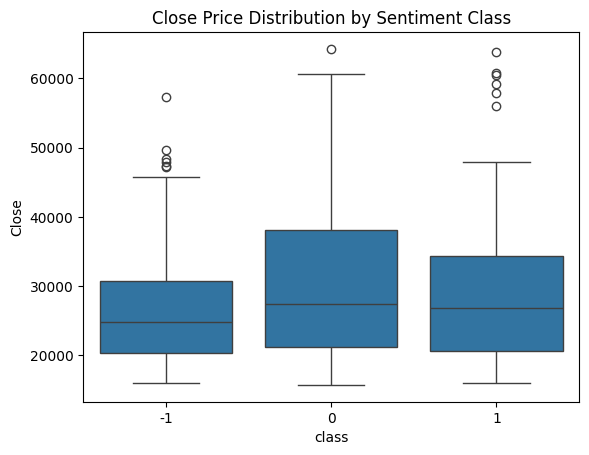

In [287]:
%matplotlib inline
import seaborn as sns

df= merged_table.to_df()
sns.boxplot(x='class', y='Close', data=df)
plt.title('Close Price Distribution by Sentiment Class')
plt.show()

In [288]:
downsample_rate = 50
date=df['date'][::downsample_rate]
polarity=df['polarity'][::downsample_rate]
close=df['Close'][::downsample_rate]

<function matplotlib.pyplot.show(close=None, block=None)>

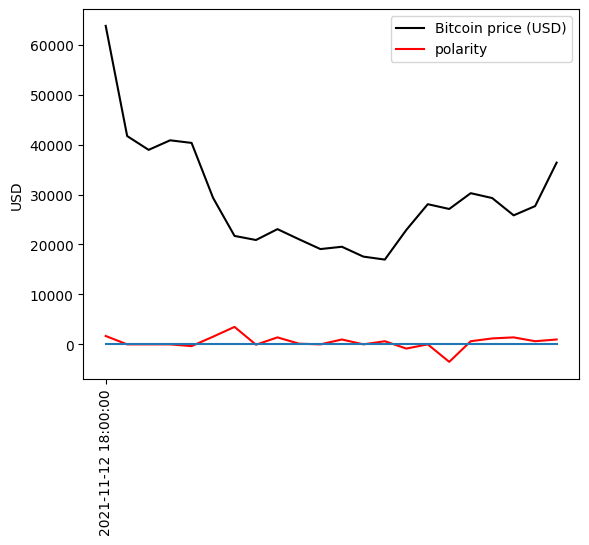

In [289]:
plt.figure()
plt.plot(date,close,'k',label = 'Bitcoin price (USD)')
plt.plot(date,7000*polarity,'r',label = 'polarity')
plt.plot(date,np.zeros(len(date)))
plt.ylabel('USD')
plt.xticks(date[::100],rotation='vertical')
plt.legend()
plt.show

In [290]:
from scipy.stats import f_oneway

negative = df[df['class'] == -1]['Close']
neutral = df[df['class'] == 0]['Close']
positive = df[df['class'] == 1]['Close']

stat, p_value = f_oneway(negative, neutral, positive)

print(f"ANOVA Statistic: {stat}, p-value: {p_value}")
if p_value < 0.05:
    print("Significant difference in Close Price across sentiment classes.")
else:
    print("No significant difference in Close Price across sentiment classes.")

ANOVA Statistic: 3.589619658842377, p-value: 0.027940576066126252
Significant difference in Close Price across sentiment classes.
